In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import glob
from collections import namedtuple
from typing import Optional, Union, List

import os
import datasets as hfds
import huggingface_hub as hfhub
import torch
import torchvision.transforms.functional as tff
import matplotlib.pyplot as plt

/home/antonxue/lib/miniconda3/envs/exlib/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hfhub.login(os.getenv("HF_TOKEN"))

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/antonxue/.cache/huggingface/token
Login successful


In [3]:
VIDEO_GLOBS = \
      [f"AdnanSet_LC_{i}_*" for i in range(1,165)] \
    + [f"AminSet_LC_{i}_*" for i in range(1,11)] \
    + [f"cholec80_video0{i}_*" for i in range(1,10)] \
    + [f"cholec80_video{i}_*" for i in range(10,81)] \
    + ["HokkaidoSet_LC_1_*", "HokkaidoSet_LC_2_*"] \
    + [f"M2CCAI2016_video{i}_*" for i in range(81,122)] \
    + [f"UTSWSet_Case_{i}_*" for i in range(1,13)] \
    + [f"WashUSet_LC_01_*"]

class AbdomenOrgans(Dataset):
    def __init__(self,
                 data_dir,
                 images_dirname = "images",
                 gonogo_labels_dirname = "gonogo_labels",
                 organ_labels_dirname = "organ_labels",
                 split = "train",
                 train_ratio = 0.8,
                 image_height = 384,  # Default image height / widths
                 image_width = 640,
                 image_transforms = None,
                 label_transforms = None,
                 split_seed = 1234,
                 download = False):
        if download:
            raise ValueError("download not implemented")

        self.data_dir = data_dir
        self.images_dir = os.path.join(data_dir, images_dirname)
        self.gonogo_labels_dir = os.path.join(data_dir, gonogo_labels_dirname)
        self.organ_labels_dir = os.path.join(data_dir, organ_labels_dirname)

        self.split = split

        # Split not regarding video
        torch.manual_seed(split_seed)
        if split == "train" or split == "test":
            all_image_filenames = sorted(os.listdir(self.images_dir))
            num_all, num_train = len(all_image_filenames), int(len(all_image_filenames) * train_ratio)
            idx_perms = torch.randperm(num_all)
            todo_idxs = idx_perms[:num_train] if split == "train" else idx_perms[num_train:]
            self.image_filenames = sorted([all_image_filenames[i] for i in todo_idxs])

        # Split by the video source
        elif split == "train_video" or split == "test_video":
            num_all, num_train = len(VIDEO_GLOBS), int(len(VIDEO_GLOBS) * train_ratio)
            idx_perms = torch.randperm(num_all)
            todo_idxs = idx_perms[:num_train] if "train" in split else idx_perms[num_train:]

            image_filenames = []
            for idx in todo_idxs:
                image_filenames += glob.glob(os.path.join(self.images_dir, VIDEO_GLOBS[idx]))
            image_filenames = [os.path.basename(f) for f in image_filenames]
            self.image_filenames = sorted(image_filenames)

        else:
            raise NotImplementedError()

        self.image_height = image_height
        self.image_width = image_width

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_file = os.path.join(self.images_dir, self.image_filenames[idx])
        organ_label_file = os.path.join(self.organ_labels_dir, self.image_filenames[idx])
        gonogo_label_file = os.path.join(self.gonogo_labels_dir, self.image_filenames[idx])

        # Read image and label
        image = Image.open(image_file).convert("RGB")
        organ_label = Image.open(organ_label_file).convert("L") # L is grayscale
        gonogo_label = Image.open(gonogo_label_file).convert("L")

        filename = os.path.basename(image_file)
        
        return {
            "image": image,
            "organ": organ_label,
            "gonogo": gonogo_label,
            "id": filename
        }
        

In [4]:
train_dataset = AbdomenOrgans("/home/antonxue/foo/data/abdomen_dafe/", split="train_video")
test_dataset = AbdomenOrgans("/home/antonxue/foo/data/abdomen_dafe/", split="test_video")

In [5]:
len(train_dataset), len(test_dataset)

(785, 230)

In [6]:
train_dataset[0]

{'image': <PIL.Image.Image image mode=RGB size=640x360>,
 'organ': <PIL.Image.Image image mode=L size=640x360>,
 'gonogo': <PIL.Image.Image image mode=L size=640x360>,
 'id': 'M2CCAI2016_video100_003.png'}

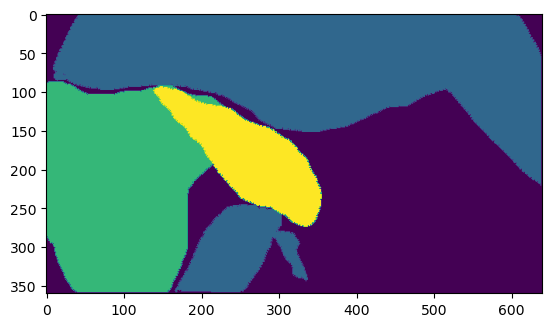

In [7]:
plt.clf()
plt.imshow(train_dataset[0]["organ"])

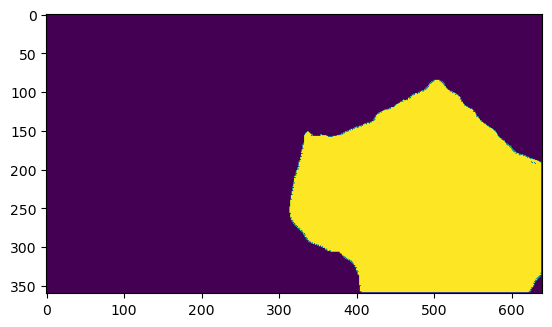

In [8]:
plt.clf()
plt.imshow(train_dataset[0]["gonogo"])

In [9]:
def gen_train():
    for it in train_dataset:
        yield it

def gen_test():
    for it in test_dataset:
        yield it

In [10]:
hfds_train = hfds.Dataset.from_generator(gen_train)

Generating train split: 785 examples [00:39, 19.90 examples/s] 


In [11]:
hfds_test = hfds.Dataset.from_generator(gen_test)

Generating train split: 230 examples [00:11, 20.19 examples/s] 


In [12]:
hfds_all = hfds.DatasetDict({
    "train": hfds_train,
    "test": hfds_test
})

In [13]:
hfds_all

DatasetDict({
    train: Dataset({
        features: ['image', 'organ', 'gonogo', 'id'],
        num_rows: 785
    })
    test: Dataset({
        features: ['image', 'organ', 'gonogo', 'id'],
        num_rows: 230
    })
})

In [17]:
# hfds_all.push_to_hub("BrachioLab/cholec")

Map: 100%|██████████████████████████████████████████████████████████████████| 785/785 [00:00<00:00, 1915.45 examples/s]

Map: 100%|██████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 1971.35 examples/s]

Uploading the dataset shards: 100%|██████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.76s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/BrachioLab/cholec/commit/fdbc539decca47c492d27d7d6806ec281dd0ad65', commit_message='Upload dataset', commit_description='', oid='fdbc539decca47c492d27d7d6806ec281dd0ad65', pr_url=None, pr_revision=None, pr_num=None)